In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import category_encoders as ce

# Load data
df = pd.read_csv('./data/230106_frozen_metadata.csv.gz', low_memory=False)
df = df.dropna(subset=['organism_name']).reset_index(drop=True)

2023-07-07 17:09:47.862725: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df

,structure_wikidata,structure_inchikey,structure_inchi,structure_smiles,structure_molecular_formula,structure_exact_mass,structure_xlogp,structure_smiles_2D,structure_cid,structure_nameIupac,...,organism_taxonomy_04class,organism_taxonomy_05order,organism_taxonomy_06family,organism_taxonomy_07tribe,organism_taxonomy_08genus,organism_taxonomy_09species,organism_taxonomy_10varietas,reference_wikidata,reference_doi,manual_validation
0,http://www.wikidata.org/entity/Q43656,HVYWMOMLDIMFJA-DPAQBDIFSA-N,InChI=1S/C27H46O/c1-18(2)7-6-8-19(3)23-11-12-2...,CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C...,C27H46O,386.354866,7.3887,CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C,5997.0,"(3S,8S,9S,10R,13R,14S,17R)-10,13-dimethyl-17-[...",...,Magnoliopsida,Saxifragales,Crassulaceae,NaN,Kalanchoe,Kalanchoe daigremontiana,NaN,http://www.wikidata.org/entity/Q104415177,10.1016/0031-9422(90)85251-A,NaN
1,http://www.wikidata.org/entity/Q27137775,PBWOIPCULUXTNY-LBKBYZTLSA-N,InChI=1S/C31H52O2/c1-8-23(20(2)3)10-9-21(4)27-...,CC[C@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C...,C31H52O2,456.396731,8.5956,CCC(CCC(C)C1CCC2C3CC=C4CC(OC(C)=O)CCC4(C)C3CCC...,5354503.0,"[(3S,8S,9S,10R,13R,14S,17R)-17-[(2R,5R)-5-ethy...",...,Magnoliopsida,Saxifragales,Crassulaceae,NaN,Kalanchoe,Kalanchoe daigremontiana,NaN,http://www.wikidata.org/entity/Q104415177,10.1016/0031-9422(90)85251-A,NaN
2,http://www.wikidata.org/entity/Q27137775,PBWOIPCULUXTNY-LBKBYZTLSA-N,InChI=1S/C31H52O2/c1-8-23(20(2)3)10-9-21(4)27-...,CC[C@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C...,C31H52O2,456.396731,8.5956,CCC(CCC(C)C1CCC2C3CC=C4CC(OC(C)=O)CCC4(C)C3CCC...,5354503.0,"[(3S,8S,9S,10R,13R,14S,17R)-17-[(2R,5R)-5-ethy...",...,Magnoliopsida,Saxifragales,Crassulaceae,NaN,Kalanchoe,Kalanchoe daigremontiana,NaN,http://www.wikidata.org/entity/Q104415177,10.1016/0031-9422(90)85251-A,NaN
3,http://www.wikidata.org/entity/Q121802,KZJWDPNRJALLNS-VJSFXXLFSA-N,InChI=1S/C29H50O/c1-7-21(19(2)3)9-8-20(4)25-12...,CC[C@H](CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C...,C29H50O,414.386166,8.0248,CCC(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C,222284.0,"(3S,8S,9S,10R,13R,14S,17R)-17-[(2R,5R)-5-ethyl...",...,Magnoliopsida,Saxifragales,Crassulaceae,NaN,Kalanchoe,Kalanchoe daigremontiana,NaN,http://www.wikidata.org/entity/Q104415177,10.1016/0031-9422(90)85251-A,NaN
4,http://www.wikidata.org/entity/Q27109256,INDVLXYUCBVVKW-PXBBAZSNSA-N,InChI=1S/C28H46O/c1-18(2)19(3)7-8-20(4)24-11-1...,C=C(CC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@...,C28H46O,398.354866,7.5548,C=C(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C,92113.0,"(3S,8S,9S,10R,13R,14S,17R)-10,13-dimethyl-17-[...",...,Magnoliopsida,Saxifragales,Crassulaceae,NaN,Kalanchoe,Kalanchoe daigremontiana,NaN,http://www.wikidata.org/entity/Q104415177,10.1016/0031-9422(90)85251-A,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792359,http://www.wikidata.org/entity/Q739601,CIEYTVIYYGTCCI-UHFFFAOYSA-N,InChI=1S/C15H14O3/c1-9(2)7-8-12-13(16)10-5-3-4...,CC(C)=CCC1=C(O)C(=O)c2ccccc2C1=O,C15H14O3,242.094294,3.2340,CC(C)=CCC1=C(O)C(=O)c2ccccc2C1=O,NaN,NaN,...,Magnoliopsida,Lamiales,Bignoniaceae,NaN,Tabebuia,Tabebuia rosea,NaN,http://www.wikidata.org/entity/Q44130314,10.1055/S-0028-1097524,NaN
792360,http://www.wikidata.org/entity/Q739601,CIEYTVIYYGTCCI-UHFFFAOYSA-N,InChI=1S/C15H14O3/c1-9(2)7-8-12-13(16)10-5-3-4...,CC(C)=CCC1=C(O)C(=O)c2ccccc2C1=O,C15H14O3,242.094294,3.2340,CC(C)=CCC1=C(O)C(=O)c2ccccc2C1=O,NaN,NaN,...,Magnoliopsida,Lamiales,Bignoniaceae,NaN,Tabebuia,Tabebuia rosea,NaN,http://www.wikidata.org/entity/Q104959700,10.1016/0031-9422(73)80710-1,NaN
792361,http://www.wikidata.org/entity/Q739601,CIEYTVIYYGTCCI-UHFFFAOYSA-N,InChI=1S/C15H14O3/c1-9(2)7-8-12-13(16)10-5-3-4...,CC(C)=CCC1=C(O)C(=O)c2ccccc2C1=O,C15H14O3,242.094294,3.2340,CC(C)=CCC1=C(O)C(=O)c2ccccc2C1=O,NaN,NaN,...,Magnoliopsida,Lamiales,Bignoniaceae,Coleeae,Phyllarthron,Phyllarthron comorense,NaN,http://www.wikidata.org/entity/Q104959696,10.1016/0031-9422(73)80045-7,NaN
792362,http

In [5]:
#Remove duplicate organism-molecule pair
df_agg = df.groupby(['organism_name',
                     'structure_smiles_2D']).size().reset_index(name='reference_wikidata')

df_agg = df.groupby(['organism_name', 'structure_smiles_2D']).agg({
    'reference_wikidata': 'size',
    'organism_taxonomy_08genus': 'first',
    'organism_taxonomy_06family': 'first',
    'organism_taxonomy_05order': 'first',
    'organism_taxonomy_04class': 'first',
    'organism_taxonomy_03phylum': 'first',
    'organism_taxonomy_02kingdom': 'first',
    'organism_taxonomy_01domain': 'first',
    'structure_taxonomy_classyfire_01kingdom': 'first',
    'structure_taxonomy_classyfire_02superclass': 'first',
    'structure_taxonomy_classyfire_03class': 'first',
    'structure_taxonomy_classyfire_04directparent' : 'first'
    # add other columns here as needed
}).reset_index()

df_agg['total_papers_molecule'] = df_agg.groupby(
    'structure_smiles_2D')['reference_wikidata'].transform('sum')
df_agg['total_papers_species'] = df_agg.groupby(
    'organism_name')['reference_wikidata'].transform('sum')

#get random subset of the database (comment to have the full DB)
df_agg = df_agg.sample(n=50000, random_state=42).reset_index(drop=True)

(array([3.0804e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2413e+04,
        0.0000e+00, 2.1370e+03, 0.0000e+00, 2.5600e+03, 3.6000e+02,
        7.2300e+02, 1.2700e+02, 3.8700e+02, 1.4100e+02, 1.2000e+02,
        6.2000e+01, 5.2000e+01, 4.2000e+01, 2.3000e+01, 1.6000e+01,
        1.2000e+01, 1.0000e+00, 4.0000e+00, 5.0000e+00, 5.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.17309856, 0.34619712, 0.51929569, 0.69239425,
        0.86549281, 1.03859137, 1.21168993, 1.38478849, 1.55788706,
        1.73098562, 1.90408418, 2.07718274, 2.2502813 , 2.42337986,
        2.59647843, 2.76957699, 2.94267555, 3.11577411, 3.28887267,
        3.46197123, 3.6350698 , 3.80816836, 3.98126692, 4.15436548,
        4.32746404, 4.5005626 , 4.67366117, 4.84675973, 5.01985829,
        5.19295685]),
 <BarContainer object of 30 artists>)

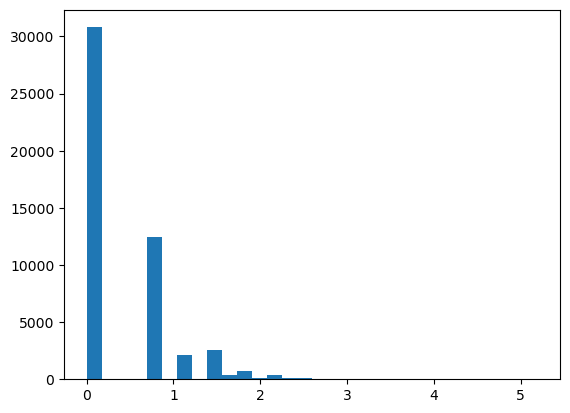

In [16]:
import matplotlib.pyplot as plt
plt.hist(np.log(df_agg.reference_wikidata), bins=30)

In [ ]:
df_agg.structure_smiles_2D.to_csv("./data/smiles_struct.csv")

In [ ]:
# Fetch unique species and molecules and their respective features
unique_species_df = df_agg.drop_duplicates(subset=['organism_name'])
unique_molecules_df = df_agg.drop_duplicates(subset=['structure_smiles_2D'])

# Fetch the corresponding features
species_features_df = unique_species_df[['organism_taxonomy_01domain', 'organism_taxonomy_02kingdom',
          'organism_taxonomy_03phylum', 'organism_taxonomy_04class',
         'organism_taxonomy_05order', 'organism_taxonomy_06family',
         'organism_taxonomy_08genus', 'organism_name']]
molecule_features_df = unique_molecules_df[['structure_taxonomy_classyfire_01kingdom',
                                            'structure_taxonomy_classyfire_02superclass',
                                            'structure_taxonomy_classyfire_03class',
                                            'structure_taxonomy_classyfire_04directparent']]


# create features
encoder = ce.BinaryEncoder(cols=[col for col in species_features_df.columns])
species_features_dummy = encoder.fit_transform(species_features_df)

#molecule_features_dummy = pd.get_dummies(molecule_features_df)
species_features_dummy.index = [i for i in unique_species_df['organism_name']]
#molecule_features_dummy.index = [i for i in unique_molecules_df['structure_smiles_2D']]

In [27]:
g = nx.DiGraph()
for i, row in df_agg.iterrows():
    g.add_edge(row['structure_smiles_2D'],
               row['organism_name'],
              label="present_in")

    #create edge in oppsite direction
    g.add_edge(row['organism_name'],
               row['structure_smiles_2D'],
              label="has")
    nx.set_node_attributes(g,
                           {row['structure_smiles_2D']: 'molecule',
                            row['organism_name']: 'species'},
                           "label")
    #nx.set_edge_attributes(g,
    #                      {(row['structure_smiles_2D'],
    #                        row['organism_name']):
    #                       {'weight':row['reference_wikidata']}})
    #nx.set_edge_attributes(g,
    #                      {(row['organism_name'],
    #                       row['structure_smiles_2D']):
    #                       {'weight':row['reference_wikidata']}})

In [28]:
from itertools import combinations

# create a subset of df_agg where 'organism_taxonomy_08genus' is not null
df_agg_sub = df_agg[df_agg['organism_taxonomy_08genus'].notnull()]

# group the dataframe by 'organism_taxonomy_08genus'
grouped = df_agg_sub.groupby('organism_taxonomy_08genus')

# for each group (i.e., each unique genus), add edges between all pairs of species in the group
for genus, group in grouped:
    for species1, species2 in combinations(group['organism_name'], 2):
        g.add_edge(species1, species2, label="same_genus")
        g.add_edge(species2, species1, label="same_genus")

In [ ]:
fps = [AllChem.MolFromSmiles(i) for i in unique_molecules_df['structure_smiles_2D']]
mols  = [AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=1024) for m in fps]
mol_dum = [np.array(i) for i in mols]
mol_dum = pd.DataFrame(mol_dum)
mol_dum.index = [i for i in unique_molecules_df['structure_smiles_2D']]

# Iterate over each pair of molecules
#for i, j in itertools.combinations(range(len(fps)), 2):
#    # Calculate the Tanimoto Similarity
#    similarity = DataStructs.TanimotoSimilarity(mols[i], mols[j])
#    # If the similarity is above 0.9, add an edge
#    if similarity >= 0.8:
#        g.add_edge(unique_molecules_df['structure_smiles_2D'].values[i], 
#                  unique_molecules_df['structure_smiles_2D'].values[j],
#                  label="similar_to")
#        g.add_edge(unique_molecules_df['structure_smiles_2D'].values[j], 
#                  unique_molecules_df['structure_smiles_2D'].values[i],
#                  label="similar_to")
#        nx.set_edge_attributes(g,
#                              {(unique_molecules_df['structure_smiles_2D'].values[i],
#                              unique_molecules_df['structure_smiles_2D'].values[j]):{'weight': similarity}})
#        nx.set_edge_attributes(g,
#                              {(unique_molecules_df['structure_smiles_2D'].values[j],
#                              unique_molecules_df['structure_smiles_2D'].values[i]):{'weight': similarity}})

In [ ]:
nx.write_graphml(g, "./graph/lotus_DB_as_graph.gml")

In [ ]:
#molecule_features_dummy.to_csv("./data/molecule_features_dummy.csv.gz", compression="gzip")
species_features_dummy.to_csv("./data/species_features_dummy.csv.gz", compression="gzip")
df_agg.to_csv("./data/lotus_aggregated.csv")
mol_dum.to_csv("./data/mol_dummy_rdkit.csv.gz", compression="gzip")